In [1]:
# packages for data analysis

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

# packages for learning
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets

%load_ext autoreload
%autoreload 2

sns.set()

### data prepocessing

In [2]:
##########################################################
#### data importing 
parquet_file = 'TCV_LHD_db4ML.parquet.part'
df = pd.read_parquet(parquet_file, engine ='auto')

##########################################################
#### removing spurious data
mask = df['LDH'] == 'Ip<Ip_MIN'
df_filter = df.drop(index = df[mask].index) #remove Ip<Ip_MIN values 

df_filter = df_filter.dropna() #remove Nan values
df_filter = df_filter.reset_index(drop=True) #reset indexing
df_filter.LDH = df_filter.LDH.cat.remove_categories('Ip<Ip_MIN') #remove Ip<Ip_MIN category

discard_data = len(df.index) - len(df_filter.index) # number of data point that do not contain useful information
print('number of useless data points: ', discard_data)
print('size of filtered data set: ', len(df_filter.index))
print('size of original data set: ', len(df.index))
print(len(df_filter.index) + discard_data - len(df.index))

AttributeError: Can only use .cat accessor with a 'category' dtype

In [ ]:
# data statistical description of filtered data set
df_filter.describe()

In [3]:
df_filter['LDH'].values

array(['L', 'L', 'L', ..., 'L', 'L', 'L'], dtype=object)

In [4]:
#######################################
### data splitting
def split_data(x, y, ratio=0.90, seed=0):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    # generate random indices
    dataset_size = x.shape[0]
    indices = np.random.permutation(dataset_size)
    threshold  = int(ratio * dataset_size)
    index_train = indices[:threshold]
    index_test = indices[threshold:]
    # create split
    x_training = x[index_train]
    x_test = x[index_test]
    y_training = y[index_train]
    y_test = y[index_test]
    return x_training, x_test, y_training, y_test

In [5]:
df_filter.head()

,time,IP,PD,FIR,WP,LDH,pulse
0,0.0257,50076.167327,1.796861,5.006723e+18,0.0,L,1.0
1,0.0258,50372.816198,1.816465,5.024210e+18,0.0,L,1.0
2,0.0259,50640.227687,2.031274,5.114125e+18,0.0,L,1.0
3,0.0260,50907.639176,1.894527,5.160487e+18,0.0,L,1.0
4,0.0261,51078.462437,1.865220,5.162926e+18,0.0,L,1.0


In [6]:
X = df_filter.drop(['time','LDH','pulse'], axis =1 ).to_numpy()

## labels 
maskl = df_filter.LDH == 'L'
maskd = df_filter.LDH == 'D'
maskh = df_filter.LDH == 'H'

Y = np.vstack((maskl, maskd, maskh)).T + 0.0
Y[10000:10050, :]

print('X shape, ', X.shape)
print('Y shape, ', Y.shape)
print(Y[0,:])

X shape,  (2559098, 4)
Y shape,  (2559098, 3)
[1. 0. 0.]


In [7]:
x_train, x_test, y_train, y_test = split_data(X, Y)

In [8]:
print('x and y train shapes: ', x_train.shape, y_train.shape)
print('x and y test shapes: ', x_test.shape, y_test.shape)

x and y train shapes:  (2303188, 4) (2303188, 3)
x and y test shapes:  (255910, 4) (255910, 3)


In [9]:
x_train

array([[-3.96550125e+05,  1.36720364e+00,  2.41293435e+19,
         1.18902916e+04],
       [-2.45276911e+05,  2.52708005e+00,  2.05771626e+19,
         4.76753728e+03],
       [-1.89175155e+05,  8.54525021e-01,  3.07287242e+19,
         8.03971561e+03],
       ...,
       [-1.74133402e+05,  1.38706174e+00,  2.60728573e+19,
         6.10206483e+03],
       [-1.41622618e+05,  1.85966085e+00,  2.18335347e+19,
         2.86955625e+03],
       [ 4.28700480e+05,  2.65147309e+00,  3.82011180e+19,
         2.15703591e+04]])

#### DEEP LEARNING

In [10]:
#convert  into tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# trim some samples, THINK HOW TO DEAL WITH THIS
x_train = x_train[:1000000, :]
y_train = y_train[:1000000, :]

x_test = x_test[:200000, :]
y_test = y_test[:200000, :]

In [11]:
x_test.shape

torch.Size([200000, 4])

Computing SC+BN


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 3, 3, 3], but got 2-dimensional input of size [1, 4] instead

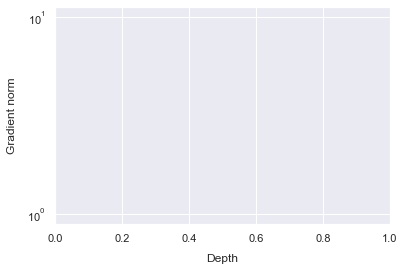

In [12]:
# first architecture with convolutions
######################################################################
train_input = x_train
train_targets = y_train

class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn2 = nn.BatchNorm2d(nb_channels)

        self.skip_connections = skip_connections
        self.batch_normalization = batch_normalization

    def forward(self, x):
        y = self.conv1(x)
        if self.batch_normalization: 
            y = self.bn1(y)
        y = F.relu(y)
        y = self.conv2(y)
        if self.batch_normalization: 
            y = self.bn2(y)
        if self.skip_connections: 
            y = y + x
        y = F.relu(y)

        return y

######################################################################

class ResNet(nn.Module):

    def __init__(self, nb_residual_blocks, nb_channels,
                 kernel_size = 3, nb_classes = 3,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv = nn.Conv2d(3, nb_channels,
                              kernel_size = kernel_size,
                              padding = (kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(nb_channels)

        self.resnet_blocks = nn.Sequential(
            *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
              for _ in range(nb_residual_blocks))
        )

        self.fc = nn.Linear(nb_channels, nb_classes)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.resnet_blocks(x)
        x = F.avg_pool2d(x, 32).view(x.size(0), -1)
        x = self.fc(x)
        return x

######################################################################

def get_stats(skip_connections, batch_normalization, nb_samples = 1000):

    model = ResNet(nb_residual_blocks = 5, nb_channels = 1,
                   kernel_size = 3, nb_classes = 3,
                   skip_connections = skip_connections, batch_normalization = batch_normalization)

    criterion = nn.CrossEntropyLoss()

    monitored_parameters = [ b.conv1.weight for b in model.resnet_blocks ]

    result = torch.empty(len(monitored_parameters), nb_samples)

    for n in range(nb_samples):
        output = model(train_input[n:n+1])
        loss = criterion(output, train_targets[n:n+1])
        model.zero_grad()
        loss.backward()
        for d, p in enumerate(monitored_parameters):
            result[d, n] = p.grad.norm()

    return result

######################################################################

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Depth', labelpad = 10)
ax.set_yscale('log')
ax.set_ylabel('Gradient norm', labelpad = 10)

graph_param = [
    ( True,   True, 'tab:red', 'SC+BN' ),
    ( True,  False, 'tab:green', 'SC' ),
    ( False,  True, 'tab:blue', 'BN' ),
    ( False, False, 'tab:orange', 'None' ),
]

for sc, bn, color, label in graph_param:
    print('Computing ' + label)
    x = get_stats(skip_connections = sc, batch_normalization = bn)
    ax.plot(x.mean(1).numpy(), color = color, label = label)

ax.legend(frameon = True)

plt.show()

In [13]:
# basic architecture with no convolutions
mini_batch_size = 500
######################################################################
def train_model(model, train_input, train_target):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    nb_epochs = 1

    for e in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
######################################################################
def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0    
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))    
        _, predicted_classes = torch.max(output, 1)
        #print('', predicted_classes)
        for k in range(mini_batch_size):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

######################################################################

def create_deep_model():
    return nn.Sequential(
        nn.Linear(4, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 3)
    )

In [14]:
for std in [ -1, 1e-3, 1e-2, 1e-1, 1e-0, 1e1 ]:
    for m in [create_deep_model ]:
        model = m()
        if std > 0:
            with torch.no_grad():
                for p in model.parameters(): p.normal_(0, std)
        train_model(model, x_train, y_train)
        #print('std {:s} {:f} train_error {:.02f}% test_error {:.02f}%'.format(
            #m.__name__,
            #std,
            #compute_nb_errors(model, x_train, y_train) / x_train.size(0) * 100),
            #compute_nb_errors(model, x_test, y_test) / x_test.size(0) * 100)


In [ ]:
200000/mini_batch_size

In [ ]:
for p in list(model.parameters()):
    print(p)

In [ ]:
def probability_to_category(prediction):
    prediction['prediction'] = prediction[['H','L','D']].idxmax(axis=1)

In [ ]:
df_filter

In [ ]:
sample = df_filter.iloc[100,0:5]
sample

In [15]:
#prediction = model(torch.tensor(sample).float())
prediction = model(x_test)

In [ ]:
#df_filter['L','D','H'] = model(torch.tensor(df_filter[]).float())
x_test.shape

In [17]:
prediction.shape

torch.Size([200000, 3])

In [18]:
prediction

tensor([[4.9442, 2.6371, 4.3777],
        [4.9442, 2.6371, 4.3777],
        [4.9442, 2.6371, 4.3777],
        ...,
        [4.9442, 2.6371, 4.3777],
        [4.9442, 2.6371, 4.3777],
        [4.9442, 2.6371, 4.3777]], grad_fn=<AddmmBackward0>)